# MTS Gold Price

## First Steps

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [2]:
import sys
sys.path.append('..')

In [3]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

### Fetch Data

In [4]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [5]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,77149,77309,77542,76545,27160,0.44
2025-01-03,76813,77246,78600,76613,60,-0.05
2025-01-02,76849,76849,76849,76849,0,0.83
2025-01-01,76214,76232,76302,76053,60,-0.02
2024-12-31,76232,75680,76970,75572,1920,0.95


### Clean the Data

In [6]:
gold_price.shape

(2848, 6)

In [7]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

np.False_

In [8]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [9]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2014-01-01,29542,29435,29598,29340,2930,0.25
2014-01-02,29975,29678,30050,29678,3140,1.47
2014-01-03,29727,30031,30125,29539,3050,-0.83
2014-01-04,29279,29279,29279,29279,0,-1.51
2014-01-06,29119,29300,29395,29051,24380,-0.55


In [10]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [11]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [12]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%', 'Volume'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price['Volume'] = gold_price['Volume'].fillna(0.0)
gold_price.head(10)

,Price,Open,High,Low,Volume,Chg%
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59


Let's drop innecessary columns

In [13]:
gold_price = gold_price.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
gold_price.head()

,Price
2014-01-01,29542.0
2014-01-02,29975.0
2014-01-03,29727.0
2014-01-04,29279.0
2014-01-05,29279.0


### Visualize the Gold Price and some simple statistics

In [14]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [15]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(np.float64(24545.0), np.float64(79257.0))

In [16]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

### Decompose the Serie

Let's check whether our time serie is additive or multiplicative.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

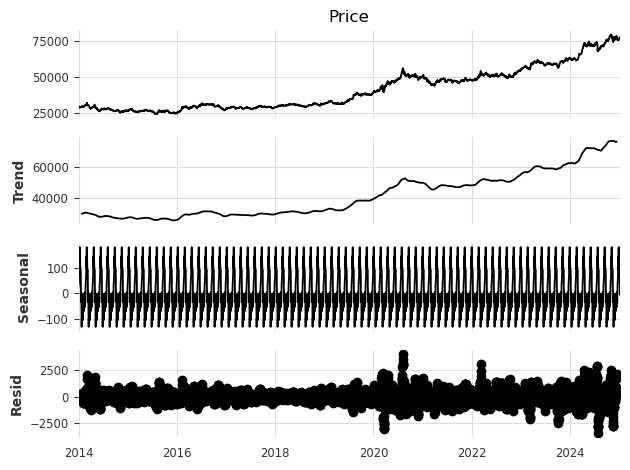

In [18]:
decompose_plot_additive = seasonal_decompose(gold_price.Price, model='additive', period=52)
decompose_plot_additive.plot()
plt.show()

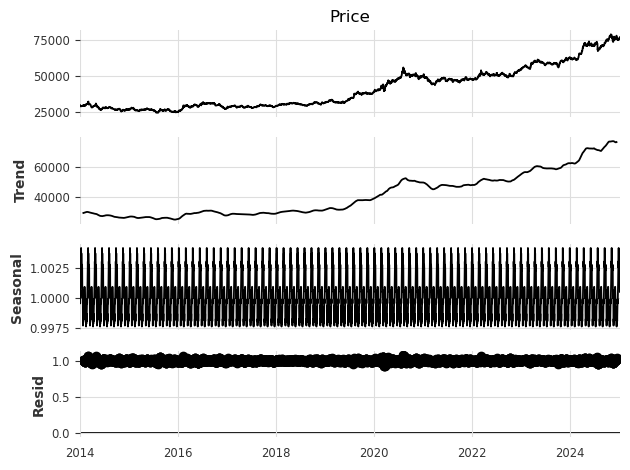

In [19]:
decompose_plot_multiplicative = seasonal_decompose(gold_price.Price, model='multiplicative', period=52)
decompose_plot_multiplicative.plot()
plt.show()

We can see that is multiplicative by the residuals, in the additive models they grow up with the time.

So, we will have to apply `log` to our serie in a future.

### Feature Engineering

In [20]:
import holidays

In [21]:
start_year = gold_price.index.min().year
end_year = gold_price.index.max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))
uk_holidays = holidays.UnitedKingdom(years=range(start_year, end_year + 1))

combined = set(us_holidays.keys()) | set(uk_holidays.keys())

idx_dates = gold_price.index.normalize().date
gold_price["is_holiday"] = [1 if d in combined else 0 for d in idx_dates]

holiday_list = sorted(list(combined))

def days_to_next(date_val: pd.Timestamp) -> int:
    for h in holiday_list:
        if h >= date_val:
            return (h - date_val).days
    return np.nan
    
gold_price['days_to_next_holiday'] = [days_to_next(d) for d in idx_dates]

gold_price.loc[:, "is_weekend"] = (gold_price.index.weekday >= 5).astype(int)

gold_price.head(10)

,Price,is_holiday,days_to_next_holiday,is_weekend
2014-01-01,29542.0,1,0,0
2014-01-02,29975.0,0,18,0
2014-01-03,29727.0,0,17,0
2014-01-04,29279.0,0,16,1
2014-01-05,29279.0,0,15,1
2014-01-06,29119.0,0,14,0
2014-01-07,28959.0,0,13,0
2014-01-08,28934.0,0,12,0
2014-01-09,28997.0,0,11,0
2014-01-10,29169.0,0,10,0


In [22]:
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

### Create train and test sets for time series

In [23]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [24]:
# Create train and test splits, 80% train, 20% test
# split_size = int(0.8 * len(price))
split_size = -37

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:2*split_size], price[:2*split_size]

# Create validation data splits (everything before the split)
X_val, y_val = timesteps[2*split_size:split_size], price[2*split_size:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

len(X_train), len(y_train), len(X_test), len(y_test)

(3950, 3950, 37, 37)

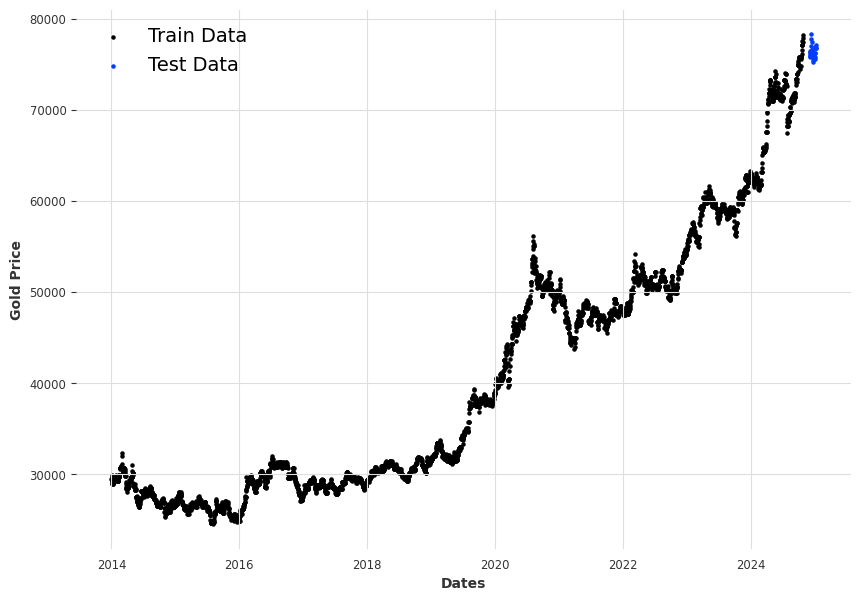

In [25]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

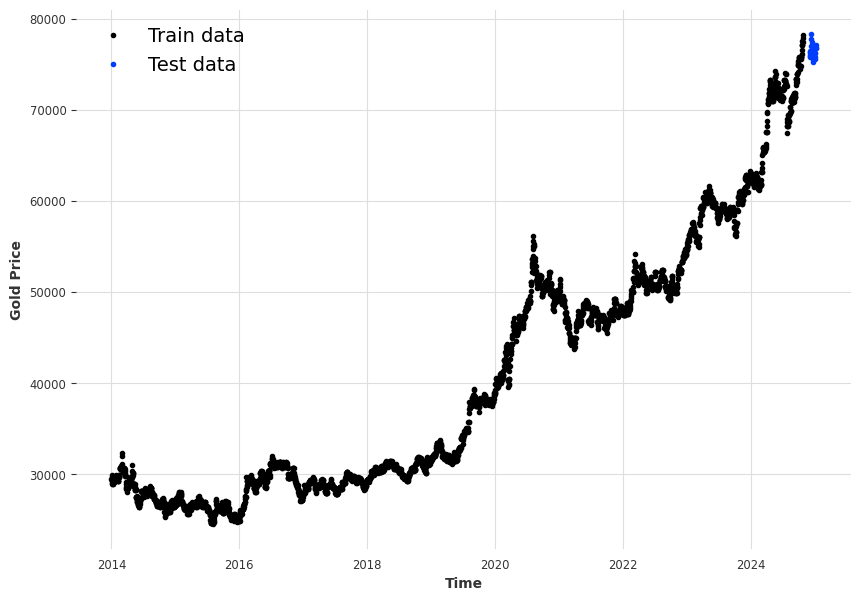

In [26]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [27]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([76485., 75815., 75934., 76036., 76353.])

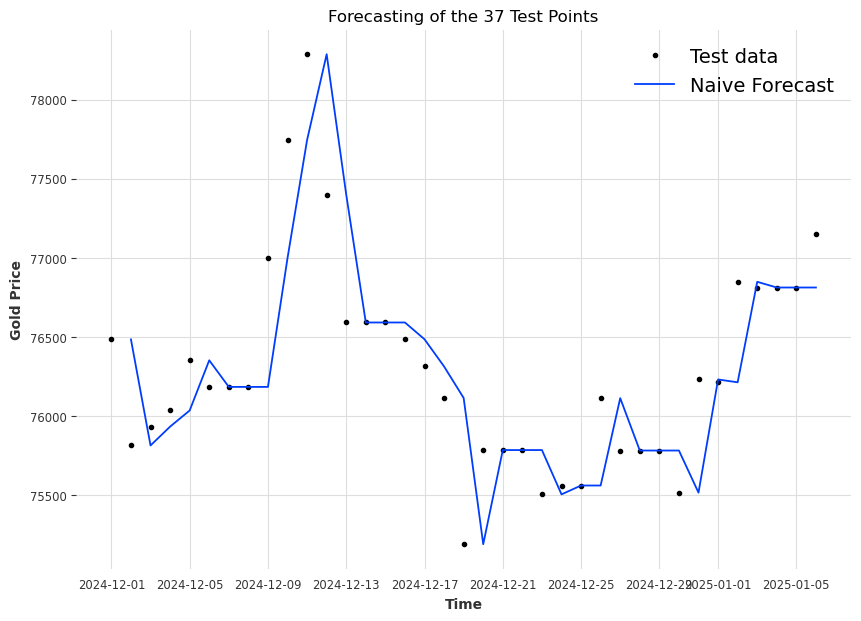

In [28]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points')
plt.show()

In [29]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': np.float32(288.72223),
 'mse': np.float32(178845.33),
 'rmse': np.float32(422.9011),
 'mape': np.float32(0.3774737)}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

We first need to apply logarithms to the serie, because we saw that it was a multiplicative model.

In [31]:
log_gold_price = np.log(gold_price.Price)
log_gold_price.head()

2014-01-01    10.293568
2014-01-02    10.308119
2014-01-03    10.299811
2014-01-04    10.284626
2014-01-05    10.284626
Freq: D, Name: Price, dtype: float64

In [32]:
# Check for stationarity (mean and variance constant)
adf = adfuller(log_gold_price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.9911734545221276


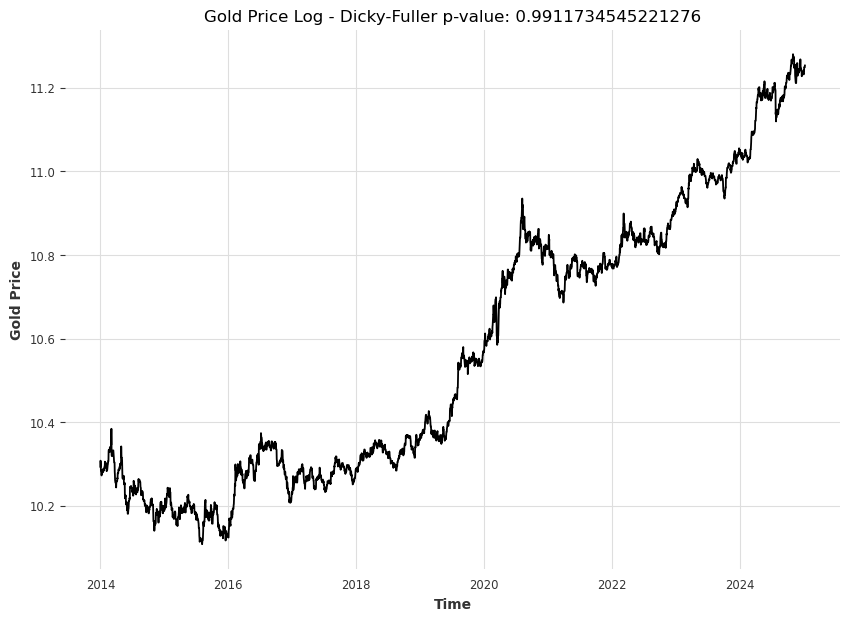

In [33]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price.index,
                 values=log_gold_price.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Log - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [34]:
# We have to differentiate, because the p-value was greater than 0.05
log_gold_price_stationarity = log_gold_price.diff().dropna()
adf_diff = adfuller(log_gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 2.8469869896195193e-30


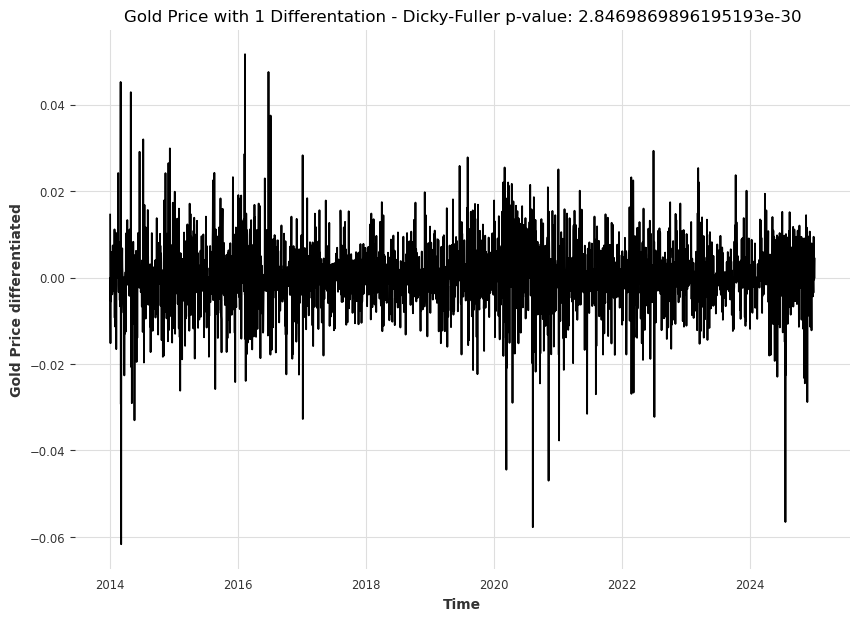

In [35]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price_stationarity.index,
                 values=log_gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

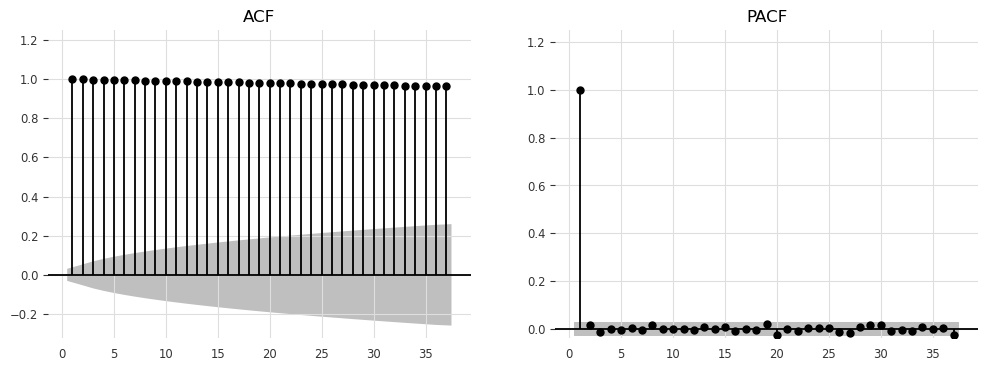

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

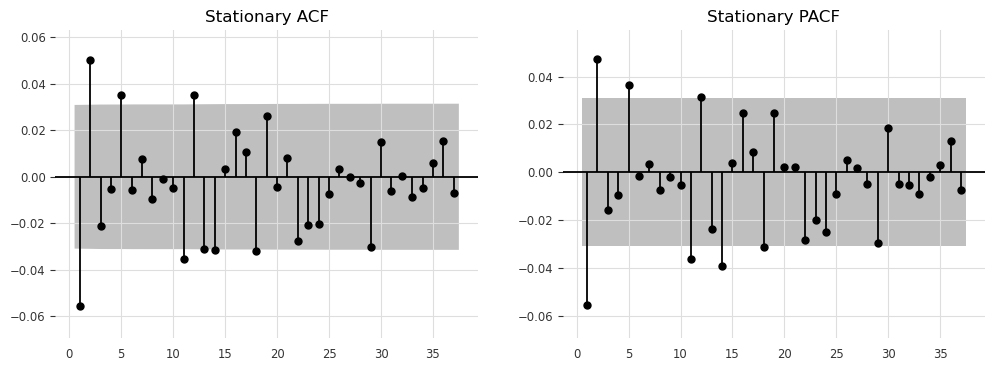

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(log_gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [38]:
log_gold_price_train = pd.Series(np.log(y_train), index=pd.DatetimeIndex(X_train, freq='D'))
log_gold_price_val = pd.Series(np.log(y_val), index=pd.DatetimeIndex(X_val, freq='D'))
log_gold_price_train_val = pd.Series(np.log(y_train_val), index=pd.DatetimeIndex(X_train_val, freq='D'))
log_gold_price_test = pd.Series(np.log(y_test), index=pd.DatetimeIndex(X_test, freq='D'))

In [39]:
model_arima_010 = ARIMA(log_gold_price_train_val, order=(0, 1, 0))
model_arima_110 = ARIMA(log_gold_price_train_val, order=(1, 1, 0))
model_arima_111 = ARIMA(log_gold_price_train_val, order=(1, 1, 1))
model_arima_112 = ARIMA(log_gold_price_train_val, order=(1, 1, 2))
model_arima_212 = ARIMA(log_gold_price_train_val, order=(2, 1, 2))

results_arima_010 = model_arima_010.fit()
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()
results_arima_212 = model_arima_212.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [40]:
results_arima_010.aic, results_arima_110.aic, results_arima_111.aic, results_arima_112.aic, results_arima_212.aic

(np.float64(-28236.047379327923),
 np.float64(-28246.130913028406),
 np.float64(-28248.629395350847),
 np.float64(-28251.841382477345),
 np.float64(-28252.313029657074))

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 2)`.

#### Make Predictions

Now, we will make the predictions using the **walk-forward** technique.

In [41]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [42]:
history = list(log_gold_price_train_val)
arima_preds = []
for obs in log_gold_price_test:
    model = ARIMA(history, order=(1, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        results = model.fit()
    log_pred = results.forecast()[0]
    arima_preds.append(np.exp(log_pred))
    history.append(obs) # take in the real observation

#### Evaluate Predicts

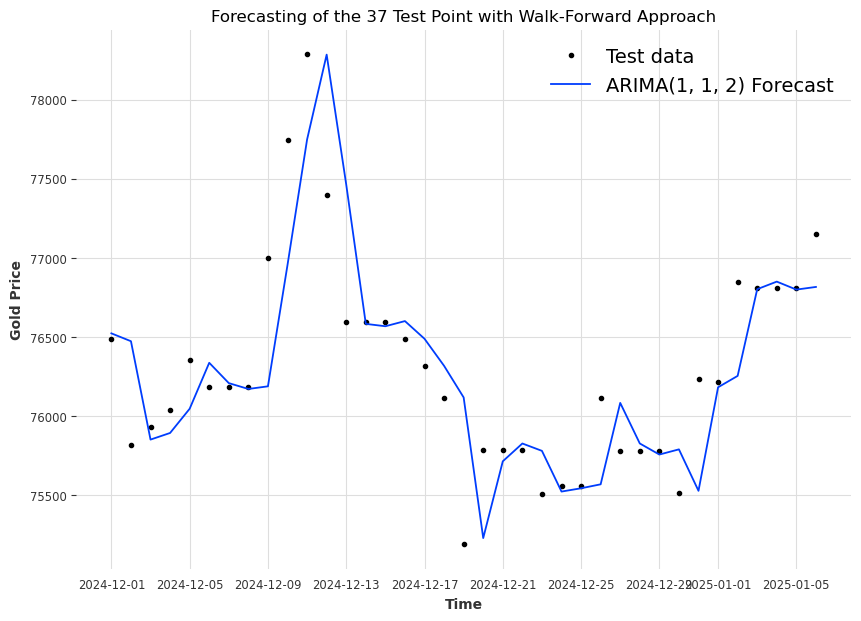

In [43]:
# Plot ARIMA(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 2) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Point with Walk-Forward Approach')
plt.show()

In [44]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': np.float32(288.50107),
 'mse': np.float32(174503.95),
 'rmse': np.float32(417.7367),
 'mape': np.float32(0.3772017)}

In [45]:
log_pred_arima_direct = results_arima_112.get_forecast(steps=37)
pred_arima_direct = np.exp(log_pred_arima_direct.predicted_mean).values
arima_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_arima_direct)
arima_direct_metrics

{'mae': np.float32(557.6049),
 'mse': np.float32(464161.5),
 'rmse': np.float32(681.294),
 'mape': np.float32(0.7308145)}

### Baseline 2: SARIMAX

Our TS is anual stational, so we would need to look at the lags 365, 730 and so on, if we want to know the parameters P and Q of the model ``SARIMAX(p, d, q)x(P, D, Q, m)``. Therefore, we will use grid search to compute the best parameters. We will try the next models:

* ``SARIMAX(0, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 2, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 2, 365)``

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Exogenus variables

First of all, we have to load, clean, transform and put all the exogenus variables into the `gold_price` dataframe.

In [47]:
from utils.load import load_csv_into_dates, load_csv_and_glue_time_series

In [48]:
folder_exogenus_gold_variables = os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold')

##### BRENT

In [49]:
brent = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'brent', 'brent-daily.csv'))
brent.index.min(), brent.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

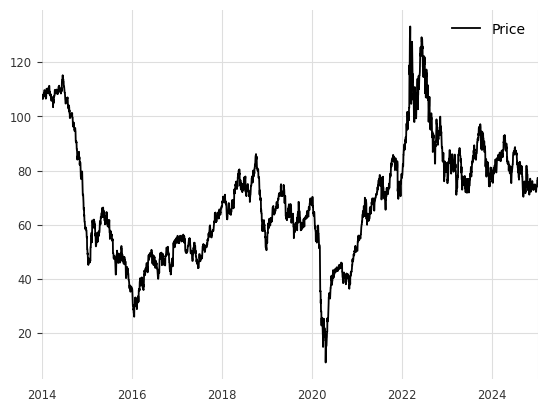

In [50]:
brent.plot()

##### WTI

In [51]:
wti = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'wti', 'wti-daily.csv'))
wti.index.min(), wti.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [52]:
wti[wti.values < 0]

,Price
2020-04-18,-36.98
2020-04-19,-36.98
2020-04-20,-36.98


<Axes: >

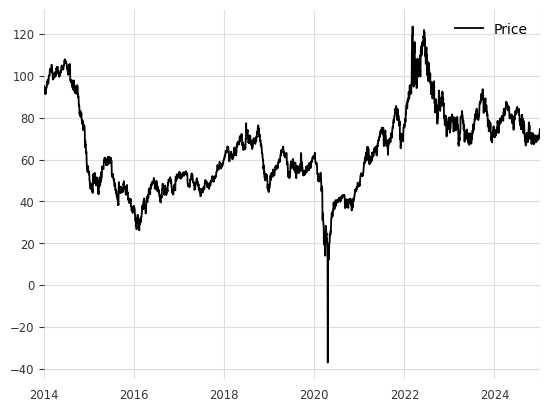

In [53]:
wti.plot()

##### DXY - Dollar Index

In [54]:
folder_dxy = os.path.join(folder_exogenus_gold_variables, 'DXY')
dxy = load_csv_and_glue_time_series(folder_path=folder_dxy, column_name='Open')
dxy.index.min(), dxy.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

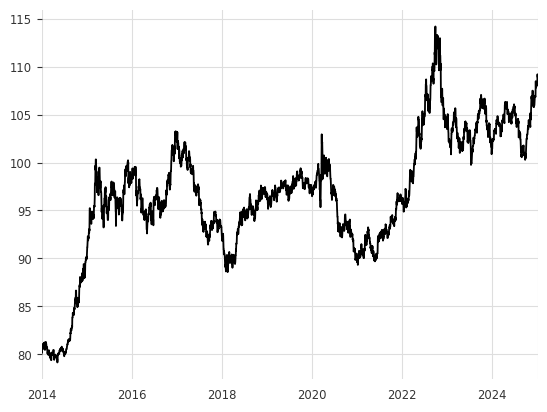

In [55]:
dxy.plot()

##### EURUSD

In [56]:
eurusd = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'EURUSD', 'EURUSD_D1.csv'), header=None)
eurusd = eurusd.iloc[:, 0]
eurusd.index.min(), eurusd.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

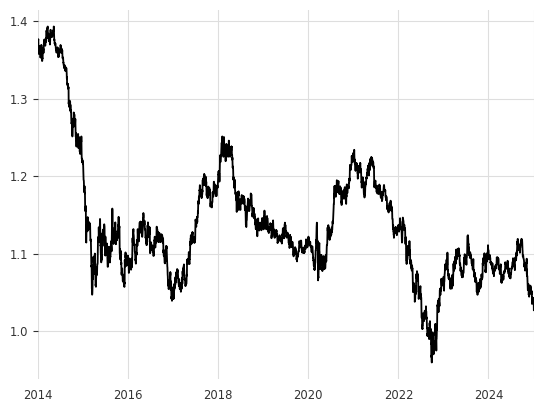

In [57]:
eurusd.plot()

##### VIX

In [58]:
vix = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'VIX', 'VIX_history.csv'),
                          column_name='OPEN')
vix.index.min(), vix.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

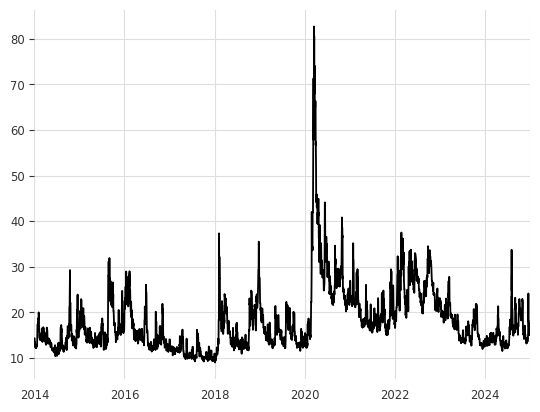

In [59]:
vix.plot()

##### S&P 500

In [60]:
sp500 = load_csv_and_glue_time_series(folder_path=os.path.join(folder_exogenus_gold_variables, 'SP500'),
                                      column_name='Open')
sp500.index.min(), sp500.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

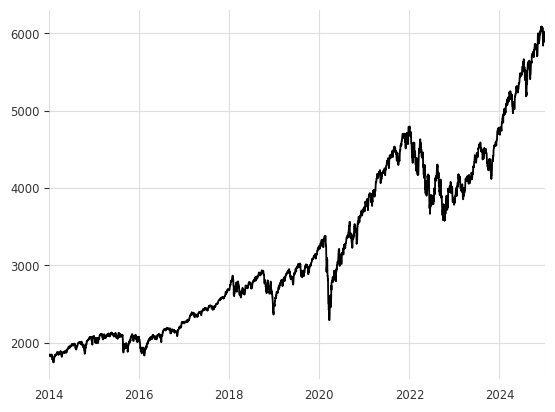

In [61]:
sp500.plot()

##### T5YIE

In [62]:
t5yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T5YIE', 'T5YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t5yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t5yie.iloc[0]
t5yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t5yie
])
t5yie.index.min(), t5yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

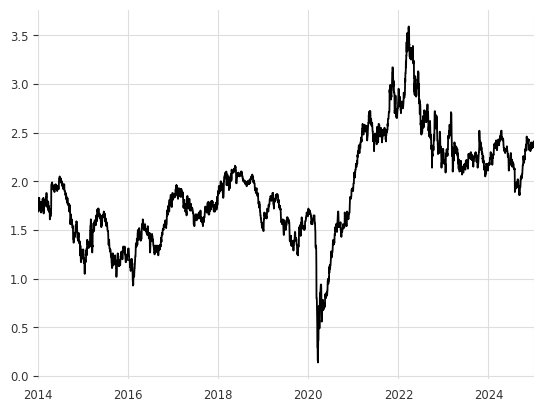

In [63]:
t5yie.plot()

##### T10YIE

In [64]:
t10yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T10YIE', 'T10YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t10yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t10yie.iloc[0]
t10yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t10yie
])
t10yie.index.min(), t10yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

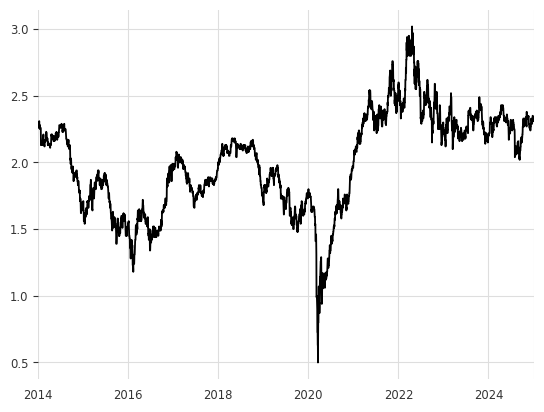

In [65]:
t10yie.plot()

#### Preparing data with Exogenus Variables

In [66]:
gold_price['brent'] = brent
gold_price['wti'] = wti
gold_price['dxy'] = dxy
gold_price['vix'] = vix
gold_price['eurusd'] = eurusd
gold_price['sp500'] = sp500
gold_price['t5yie'] = t5yie
gold_price.head()

,Price,is_holiday,days_to_next_holiday,is_weekend,brent,wti,dxy,vix,eurusd,sp500,t5yie
2014-01-01,29542.0,1,0,0,107.94,95.14,80.21,14.32,1.37553,1845.859985,1.71
2014-01-02,29975.0,0,18,0,107.94,95.14,80.12,14.32,1.37653,1845.859985,1.71
2014-01-03,29727.0,0,17,0,106.57,93.66,80.57,14.06,1.36653,1833.209961,1.69
2014-01-04,29279.0,0,16,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75
2014-01-05,29279.0,0,15,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75


We need to separate our exogenus variables from our raw gold_price dataframe. Furthermore, we will need also to split in train and test this new dataset.

In [67]:
exog_data = gold_price.reset_index().drop(columns=['index', 'Price'])
exog_data.head()

,is_holiday,days_to_next_holiday,is_weekend,brent,wti,dxy,vix,eurusd,sp500,t5yie
0,1,0,0,107.94,95.14,80.21,14.32,1.37553,1845.859985,1.71
1,0,18,0,107.94,95.14,80.12,14.32,1.37653,1845.859985,1.71
2,0,17,0,106.57,93.66,80.57,14.06,1.36653,1833.209961,1.69
3,0,16,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75
4,0,15,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75


In [68]:
exog_train = exog_data.iloc[:2*split_size, :]
exog_val = exog_data.iloc[2*split_size:split_size, :]
exog_train_val = pd.concat([exog_train, exog_val])
exog_test = exog_data.iloc[split_size:, :]

exog_train.shape, exog_val.shape, exog_train_val.shape, exog_test.shape

((3950, 10), (37, 10), (3987, 10), (37, 10))

We also need to transform our 'anual seasonality' in terms of **Fourier** for agilize the computation, and get rid of the seasonality in SARIMAX.

In [69]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

In [70]:
fourier_gen = FourierFeaturizer(m=365.25, k=4)
log_gold_price_fourier, exog_data_fourier = fourier_gen.fit_transform(log_gold_price.values, exog_data)

exog_train_fourier = exog_data_fourier.iloc[:2*split_size, :]
exog_val_fourier = exog_data_fourier.iloc[2*split_size:split_size, :]
exog_train_val_fourier = pd.concat([exog_train_fourier, exog_val_fourier])
exog_test_fourier = exog_data_fourier.iloc[split_size:, :]

exog_train_fourier.shape, exog_val_fourier.shape, exog_train_val_fourier.shape, exog_test_fourier.shape

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



((3950, 18), (37, 18), (3987, 18), (37, 18))

#### Create Model

In [71]:
# Exogenus without Fourier and without seasonality

model_sarimax_010_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_365 = model_sarimax_010_000_365.fit()
results_sarimax_110_000_365 = model_sarimax_110_000_365.fit()
results_sarimax_111_000_365 = model_sarimax_111_000_365.fit()
results_sarimax_112_000_365 = model_sarimax_112_000_365.fit()
results_sarimax_212_000_365 = model_sarimax_212_000_365.fit()

results_sarimax_010_000_365.aic, results_sarimax_110_000_365.aic, results_sarimax_111_000_365.aic, results_sarimax_112_000_365.aic, results_sarimax_212_000_365.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



(np.float64(-28258.81917047356),
 np.float64(-28276.985655355966),
 np.float64(-28278.526195146987),
 np.float64(-28279.888343391303),
 np.float64(-5931.6033544619695))

In [72]:
# Exogenus without Fourier, but with seasonality

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore", category=FutureWarning)
    model_sarimax_auto = auto_arima(
        y=log_gold_price_train_val,
        exogenus=exog_train_val,
        seasonal=True,
        m=52,
        stepwise=True,
        suppress_warnings=True,
        trace=False
    )

model_sarimax_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3987
Model:               SARIMAX(2, 1, 2)   Log Likelihood               14133.488
Date:                Mon, 22 Sep 2025   AIC                         -28254.976
Time:                        13:33:39   BIC                         -28217.233
Sample:                    01-01-2014   HQIC                        -28241.595
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.195      0.028    7.23e-05       0.001
ar.L1         -1.1518      0.150     -7.691      0.000      -1.445      -0.858
ar.L2         -0.6531      0.107     -6.084      0.000      -0.864      -0.443
ma.L1          1.0986      0.147      7.449      0.000       0.810       1.388
ma.L2          0.6448      0.101      6.381      0.000       0.447       0.843
sigma2      4.869e-05   4.95e-07     98.278      0.000    4.77e-05    4.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13091.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# Exogenus with Fourier

model_sarimax_010_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_fourier = model_sarimax_010_000_fourier.fit()
results_sarimax_110_000_fourier = model_sarimax_110_000_fourier.fit()
results_sarimax_111_000_fourier = model_sarimax_111_000_fourier.fit()
results_sarimax_112_000_fourier = model_sarimax_112_000_fourier.fit()
results_sarimax_212_000_fourier = model_sarimax_212_000_fourier.fit()

results_sarimax_010_000_fourier.aic, results_sarimax_110_000_fourier.aic, results_sarimax_111_000_fourier.aic, results_sarimax_112_000_fourier.aic, results_sarimax_212_000_fourier.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(np.float64(-28252.679195734185),
 np.float64(-28271.461850238567),
 np.float64(-28272.642984480557),
 np.float64(-28273.127557563363),
 np.float64(-28102.970070546908))

The model with lowest AIC is `SARIMAX(1, 1, 2)x(0, 0, 0, 0)` without seasonality nor Fourier's features.

#### Make Predictions

In [74]:
history = list(log_gold_price_train_val.values)
sarimax_preds = []

for i in range(len(log_gold_price_test)):

    model = SARIMAX(
        endog=history,
        exog=exog_data.iloc[:len(history)],
        order=(1, 1, 2),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        results = model.fit(disp=False)

    log_pred = results.forecast(steps=1, exog=exog_test.iloc[i:i+1])
    sarimax_preds.append(np.exp(log_pred))

    history.append(log_gold_price_test.values[i])

#### Evaluate Predicts

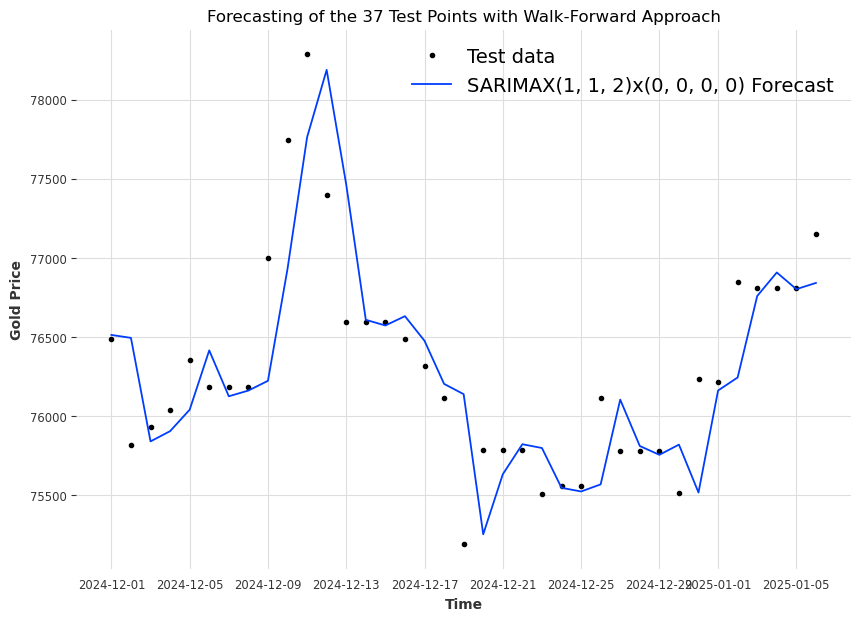

In [75]:
# Plot SARIMAX(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=sarimax_preds, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Walk-Forward Approach')
plt.show()

In [76]:
sarimax_metrics = evaluate_preds(y_true=y_test,
                                 y_pred=sarimax_preds)
sarimax_metrics

{'mae': np.float32(697.0188),
 'mse': np.float32(818114.1),
 'rmse': np.float32(904.49664),
 'mape': np.float32(0.9114891)}

In [77]:
log_pred_sarimax_direct = results_sarimax_112_000_365.get_forecast(steps=37, exog=exog_test)
pred_sarimax_direct = np.exp(log_pred_sarimax_direct.predicted_mean).values
sarimax_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_sarimax_direct)
sarimax_direct_metrics

{'mae': np.float32(518.5511),
 'mse': np.float32(401148.6),
 'rmse': np.float32(633.3629),
 'mape': np.float32(0.67884296)}

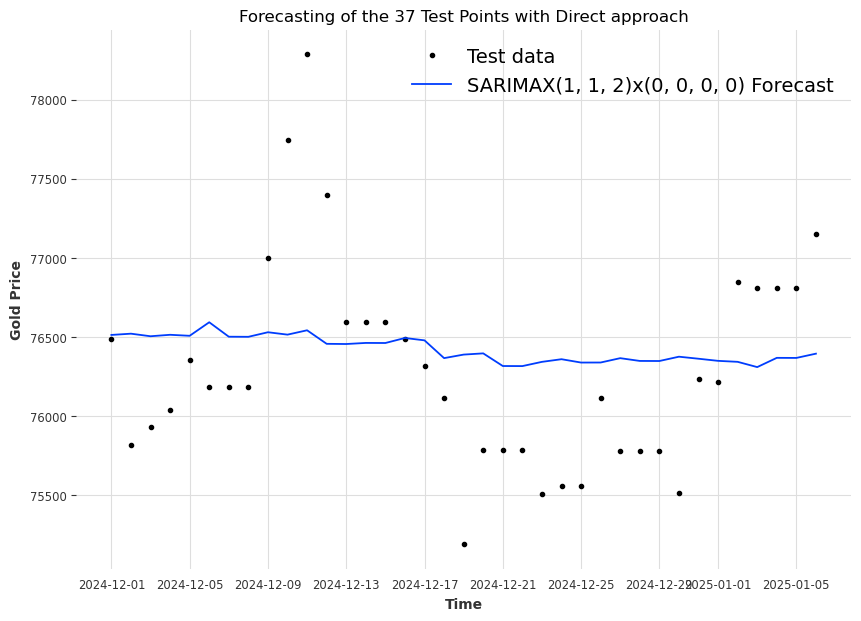

In [78]:
# Plot SARIMAX(1, 1, 2) forecast direct
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=pred_sarimax_direct, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Direct approach')
plt.show()

### Final Results for Baseline Models

| Metrics / Baselines | Naive | ARIMA | SARIMAX |
|----------------|-----------|-----------|-----------|
| MAE  | 288.35  | 288.72  | 697.02  |
| MSE  | 174403.08  | 178845.33  | 818114.06  |
| RMSE  | 422.90  | 417.62  | 861.11  |
| MAPE  | 0.38  | 0.38  | 0.91  |


## Main Models

### Make Windows

First of all, we need to transform our Forecasting Time Series problem in a Supervised Prediction problem. So, the technique that we are going to use is make windows (we will try differnt window's sizes), and use this windows like a features where our model is trained on, and the last element will be the `y` that we are trying to predict.

In [79]:
from utils.windows import make_windows

In [80]:
WINDOW_SIZE = 30
HORIZON = 1

We have to include the exogenus variables into the window-format.

In [81]:
index = pd.date_range(start='2014-01-01', periods=len(gold_price)-1, freq='D')[WINDOW_SIZE-1:]
first_iter = True
for var in gold_price.columns.values:
    columns_var = [f'{var}_{i+1}' for i in range(WINDOW_SIZE)]
    if var == 'Price':
        full_windows, full_labels = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    else:
        full_windows, _ = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    if first_iter:
        df = pd.DataFrame(full_windows, columns=columns_var, index=index)
        first_iter = False
        continue
    df2 = pd.DataFrame(full_windows, columns=columns_var, index=index)
    df = pd.concat([df, df2], axis=1)

In [82]:
gold_price_windowed = df.copy()
gold_price_windowed.head()

,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7,Price_8,Price_9,Price_10,...,t5yie_21,t5yie_22,t5yie_23,t5yie_24,t5yie_25,t5yie_26,t5yie_27,t5yie_28,t5yie_29,t5yie_30
2014-01-30,29542.0,29975.0,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,...,1.71,1.79,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76
2014-01-31,29975.0,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,...,1.79,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72
2014-02-01,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,...,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70
2014-02-02,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,29312.0,...,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70,1.70
2014-02-03,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,29312.0,29198.0,...,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70,1.70,1.70


Before continuing, we have to remove all calendar variables from 1 to 29, and only stay with the 30th.

In [83]:
calendar_vars = ["is_weekend", "is_holiday", "days_to_next_holiday"]
keep_cols = []
for var in calendar_vars:
    keep_cols.append(f"{var}_{WINDOW_SIZE}")

for col in gold_price_windowed.columns:
    if not any(col.startswith(var) for var in calendar_vars):
        keep_cols.append(col)

gold_price_windowed = gold_price_windowed[keep_cols]
len(gold_price_windowed.columns.values)

243

In [84]:
# Turning windows into training and tests sets
train_gold_price_windowed = gold_price_windowed[:2*split_size]
val_gold_price_windowed = gold_price_windowed[2*split_size:split_size]
test_gold_price_windowed = gold_price_windowed[split_size:]

train_labels = full_labels[:2*split_size]
val_labels = full_labels[2*split_size:split_size]
test_labels = full_labels[split_size:]

len(train_gold_price_windowed), len(val_gold_price_windowed), len(test_gold_price_windowed), len(train_labels), len(val_labels), len(test_labels)

(3920, 37, 37, 3920, 37, 37)

In [ ]:
train_val_gold_price_windowed = pd.concat([train_gold_price_windowed, val_gold_price_windowed])
train_val_labels = np.concatenate((train_labels, val_labels))

### LightGBM

In [85]:
import lightgbm as lgb

#### Create model

In [135]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=4,
    max_depth=2,
    min_split_gain=0.2,
    min_child_weight=100,
    min_child_samples=400,
    subsample=0.6,
    colsample_bytree=0.6,
    feature_fraction=0.6,
    reg_lambda=20.0,
    reg_alpha=5.0,
    random_state=42,
    verbose=-1
)

evals_result_lightgbm = {}

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 16074.7	valid_0's l2: 2.58395e+08
[100]	valid_0's rmse: 10401.7	valid_0's l2: 1.08196e+08
[150]	valid_0's rmse: 8983.75	valid_0's l2: 8.07078e+07
[200]	valid_0's rmse: 8494.09	valid_0's l2: 7.21495e+07
[250]	valid_0's rmse: 8139.14	valid_0's l2: 6.62455e+07
[300]	valid_0's rmse: 8106.22	valid_0's l2: 6.57108e+07
[350]	valid_0's rmse: 8283.08	valid_0's l2: 6.86094e+07
Early stopping, best iteration is:
[286]	valid_0's rmse: 8060.46	valid_0's l2: 6.49711e+07


c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



,boosting_type,'gbdt'
,num_leaves,4
,max_depth,2
,learning_rate,0.03
,n_estimators,3000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.2
,min_child_weight,100
,min_child_samples,400


#### Make predictions

In [136]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
len(pred_lightgbm), len(pred_train_lightgbm)

(37, 3920)

#### Evaluate predictions

In this model, and all the coming models, there is a possibility of overfitting, so, I will look also the metrics on the train set.

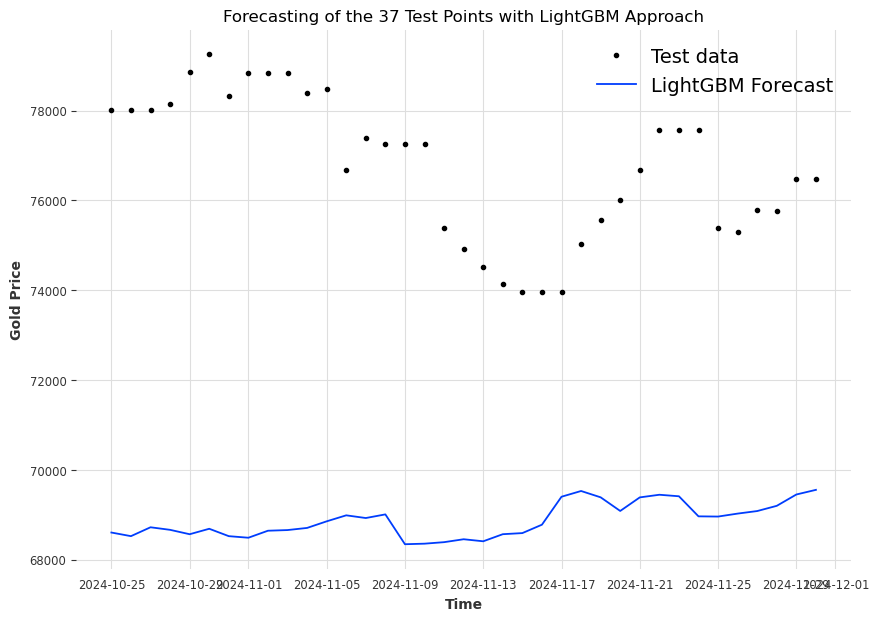

In [137]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [138]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(7878.1045),
 'mse': np.float32(64971044.0),
 'rmse': np.float32(8060.462),
 'mape': np.float32(10.223386)}

#### Evaluate Overfitting

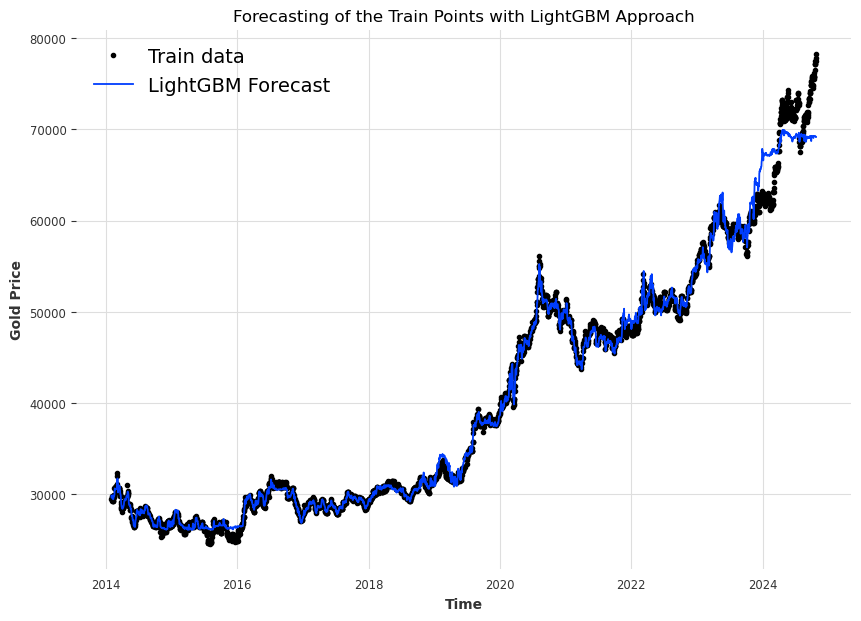

In [139]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [140]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(685.0032),
 'mse': np.float32(1578232.9),
 'rmse': np.float32(1256.2773),
 'mape': np.float32(1.4543114)}

#### Final Model and Metrics

In [141]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=4,
    max_depth=2,
    min_split_gain=0.2,
    min_child_weight=100,
    min_child_samples=400,
    subsample=0.6,
    colsample_bytree=0.6,
    feature_fraction=0.6,
    reg_lambda=20.0,
    reg_alpha=5.0,
    random_state=42,
    verbose=-1
)

model_lightgbm.fit(train_val_gold_price_windowed, train_val_labels,
                   eval_set=[(test_gold_price_windowed, test_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



,boosting_type,'gbdt'
,num_leaves,4
,max_depth,2
,learning_rate,0.03
,n_estimators,3000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.2
,min_child_weight,100
,min_child_samples,400


In [142]:
pred_lightgbm = model_lightgbm.predict(test_gold_price_windowed)

In [143]:
lightgbm_metrics = evaluate_preds(y_true=y_test,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(940.6972),
 'mse': np.float32(1470052.4),
 'rmse': np.float32(1212.4572),
 'mape': np.float32(1.2261921)}

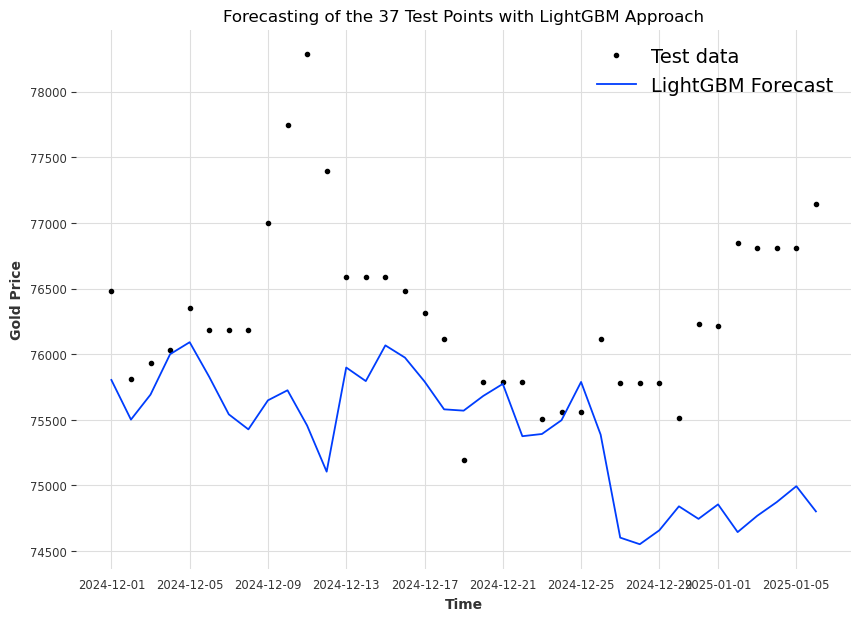

In [144]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

### N-BEATS

In [216]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

from utils.preds import make_predictions_rolling_one_darts

In [217]:
df_models_metrics_nbeats = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Prepare the data for `darts`

We have to transform our `pd.DataFrame` into a `TimeSeries` object, and scale it.

In [218]:
# Create scalers for both
scaler = Scaler()

# Create TimeSeries objects to work with darts framework
gold_price_darts_train = TimeSeries.from_dataframe(gold_price[:2*split_size], value_cols='Price')
gold_price_darts_val = TimeSeries.from_dataframe(gold_price[2*split_size:split_size], value_cols='Price')
gold_price_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols='Price')

# Scale the data
gold_price_darts_scaled_train = scaler.fit_transform(gold_price_darts_train)
gold_price_darts_scaled_val = scaler.transform(gold_price_darts_val)
gold_price_darts_scaled_test = scaler.transform(gold_price_darts_test)

In [ ]:
from darts import concatenate

gold_price_darts_scaled_train_val = concatenate([gold_price_darts_scaled_train, gold_price_darts_scaled_val])

(3987, 1, 1)

#### Default Model

##### Create model

In [219]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 123/123 [00:06<00:00, 20.28it/s, train_loss=0.000132]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [220]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [221]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


##### Evaluate Predicts

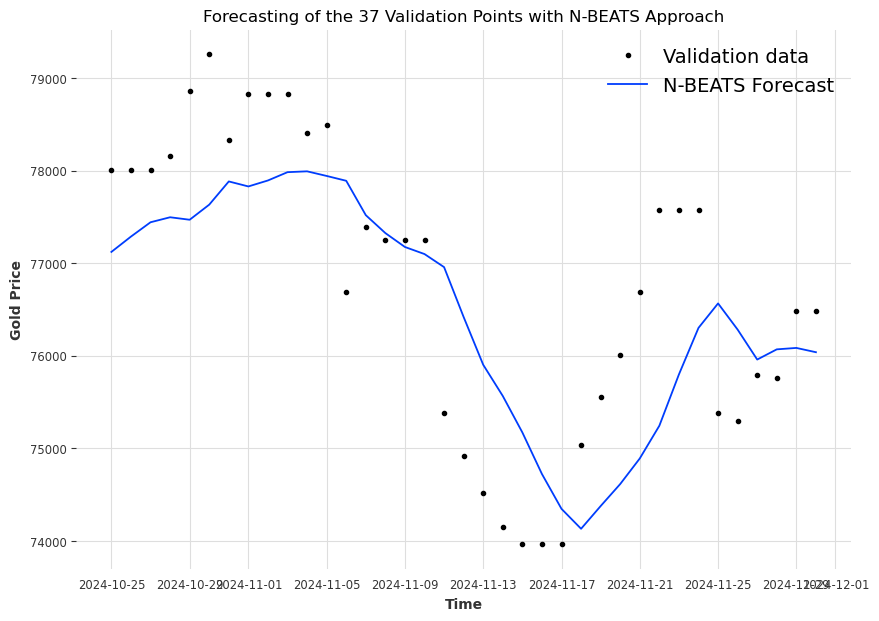

In [222]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [223]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(920.8602),
 'mse': np.float32(1155472.8),
 'rmse': np.float32(1074.9292),
 'mape': np.float32(1.2016013)}

##### Evaluate Overfitting

In [224]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.44it/s]


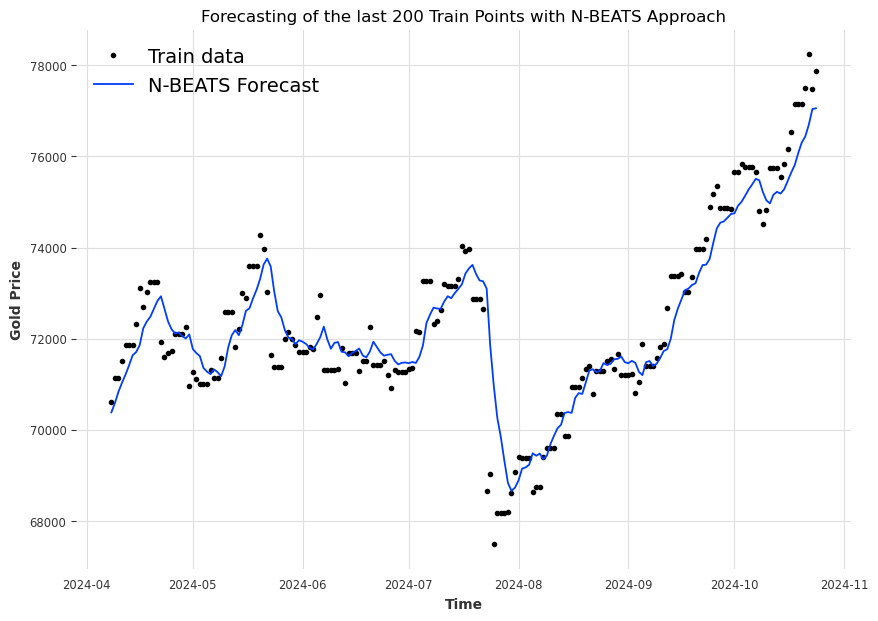

In [225]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [226]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(541.5778),
 'mse': np.float32(589747.8),
 'rmse': np.float32(767.9504),
 'mape': np.float32(0.75027794)}

##### Persist Metrics

In [227]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_1680\281432450.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Dropout Model

##### Create Model

In [228]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0.2,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 123/123 [00:07<00:00, 17.22it/s, train_loss=0.000717]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [229]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s]


##### Evaluate Predicts

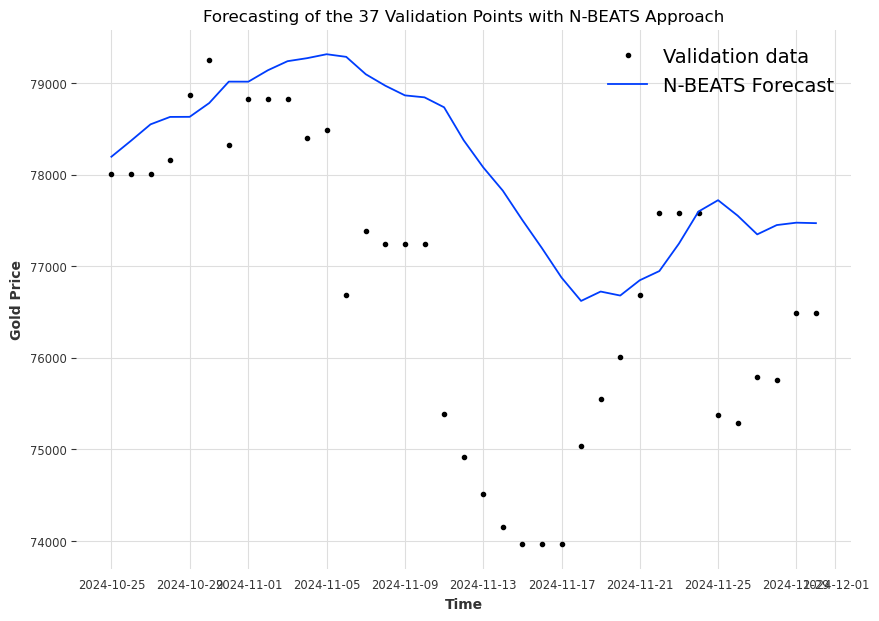

In [230]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [231]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1430.4609),
 'mse': np.float32(3365641.0),
 'rmse': np.float32(1834.5684),
 'mape': np.float32(1.8907703)}

##### Evaluate Overffiting

In [232]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


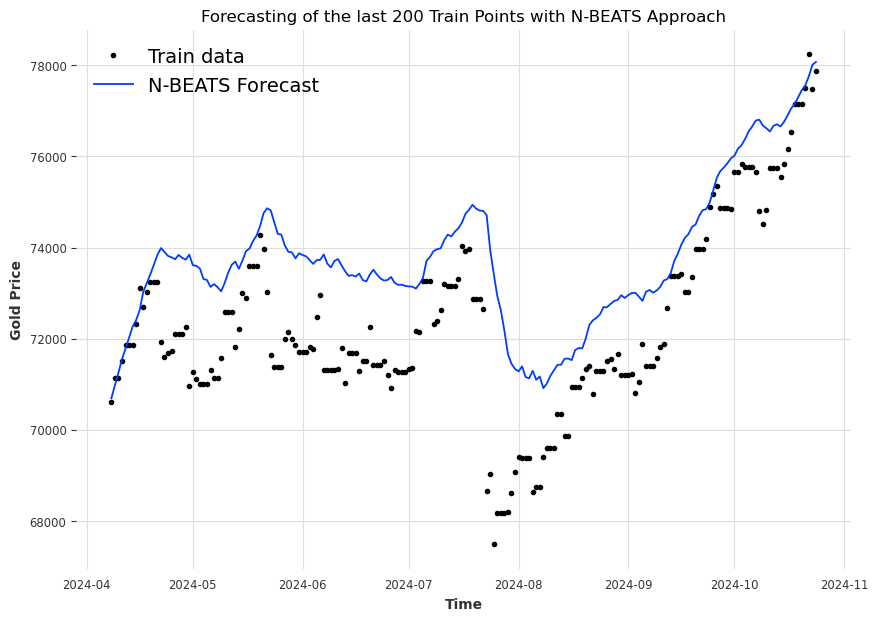

In [233]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [234]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(1457.6775),
 'mse': np.float32(3111935.0),
 'rmse': np.float32(1764.0677),
 'mape': np.float32(2.0428877)}

##### Persist Metrics

In [235]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Small Model

Less num_stacks, layer_widths and num_layers.

##### Create Model

In [238]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=6,
    num_blocks=1,
    num_layers=3,
    layer_widths=128,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 123/123 [00:01<00:00, 86.75it/s, train_loss=3.56e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=128, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [239]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.05it/s]


##### Evaluate Predictions

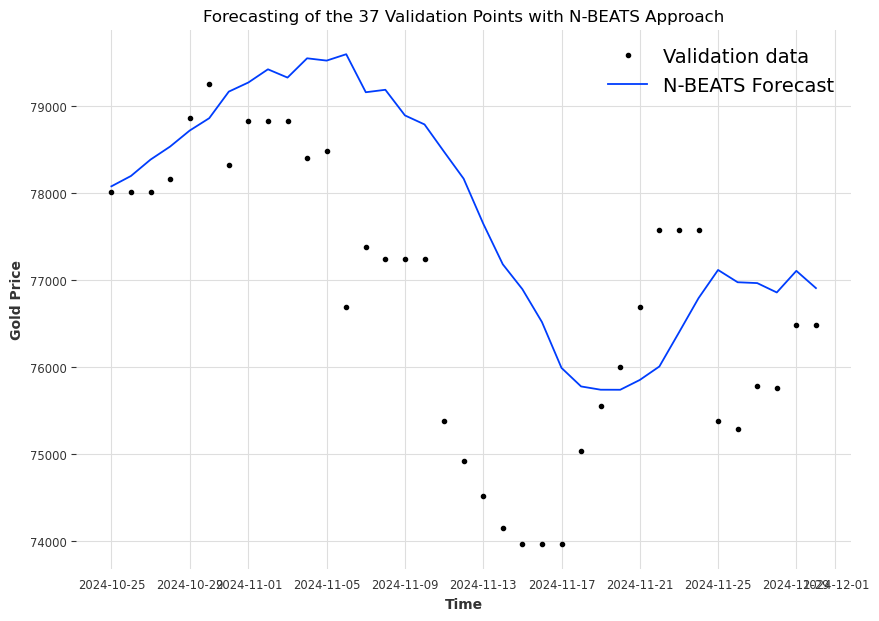

In [240]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [241]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1304.7778),
 'mse': np.float32(2652376.2),
 'rmse': np.float32(1628.6118),
 'mape': np.float32(1.7182747)}

##### Evaluate Overfitting

In [242]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.03it/s]


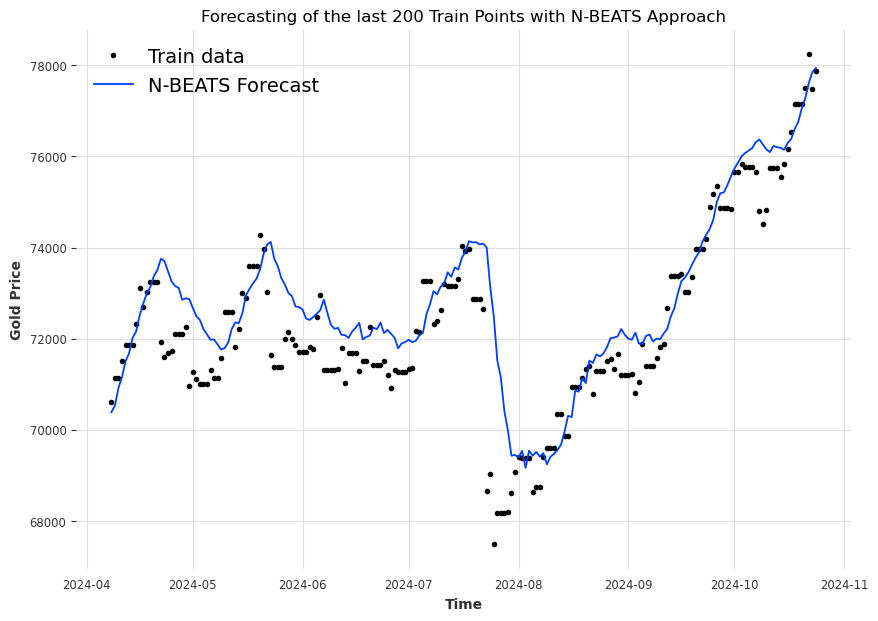

In [243]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [244]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(714.0986),
 'mse': np.float32(1084577.6),
 'rmse': np.float32(1041.4305),
 'mape': np.float32(0.9999659)}

##### Persist Metrics

In [245]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [261]:
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 38: 100%|██████████| 123/123 [00:07<00:00, 16.79it/s, train_loss=7.16e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002777A243820>]}, random_state=42)

##### Make Predictions

In [251]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


##### Evaluate Predictions

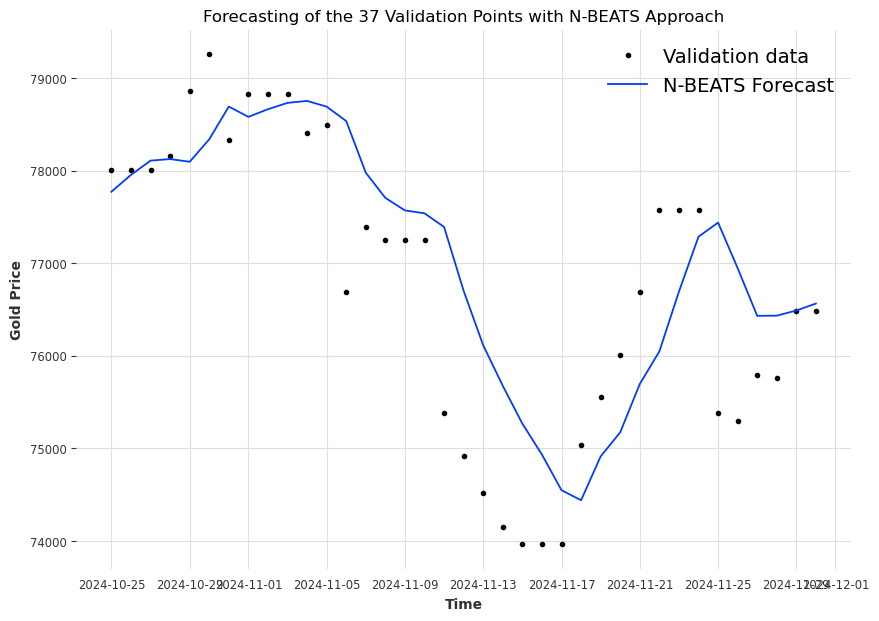

In [252]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [253]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(749.0606),
 'mse': np.float32(936724.6),
 'rmse': np.float32(967.84534),
 'mape': np.float32(0.9858305)}

##### Evaluate Overfitting

In [254]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


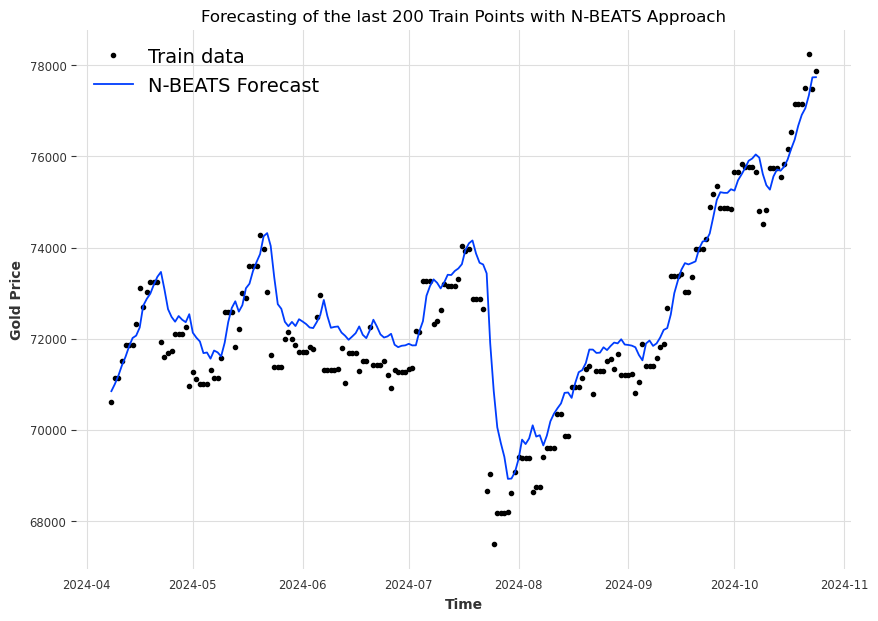

In [255]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [256]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(571.1982),
 'mse': np.float32(656065.44),
 'rmse': np.float32(809.97864),
 'mape': np.float32(0.79928774)}

##### Persist Metrics

In [257]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [258]:
df_models_metrics_nbeats

,Model,Train MAPE,Val MAPE,Train RMSE,Val RMSE
0,"NBEATSModel(input_chunk_length=30, output_chun...",1.201601,0.750278,767.950378,1074.929199
1,"NBEATSModel(dropout=0.2, input_chunk_length=30...",1.890770,2.042888,1764.067749,1834.568359
2,"NBEATSModel(num_stacks=6, num_layers=3, layer_...",1.718275,0.999966,1041.430542,1628.611816
3,"NBEATSModel(dropout=0.2, input_chunk_length=30...",0.985830,0.799288,809.978638,967.845337


In [262]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train_val)

Epoch 22: 100%|██████████| 124/124 [00:07<00:00, 17.36it/s, train_loss=0.000384]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000027779FF5990>]}, random_state=42)

In [263]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                  ts_test=gold_price_darts_scaled_test,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


In [264]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1748.8353),
 'mse': np.float32(4755145.5),
 'rmse': np.float32(2180.6296),
 'mape': np.float32(2.3122694)}

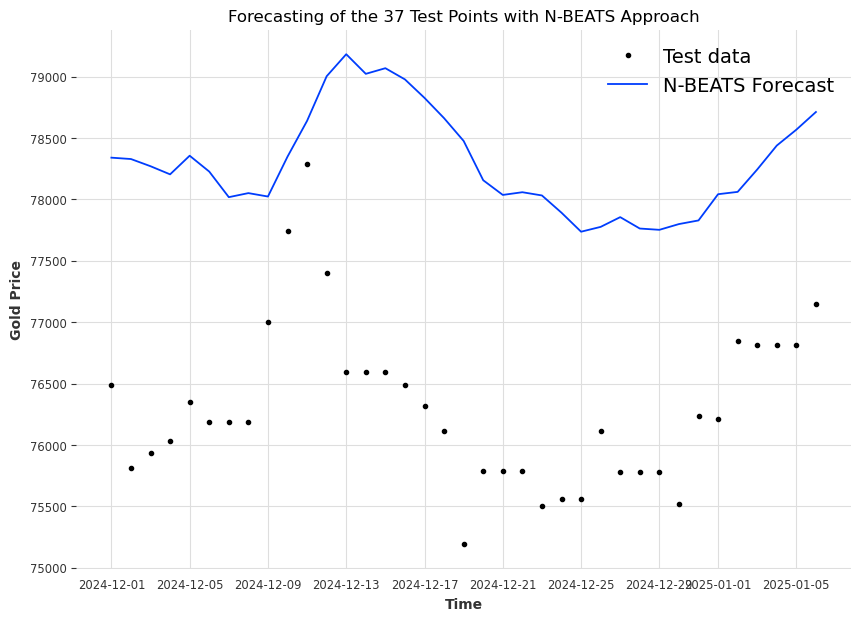

In [265]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATS Approach')
plt.show()

### LSTM - Long Short Term Memory

In [108]:
from darts.models import RNNModel

#### Preparing the data

In [109]:
# Create scaler
scaler_exogenus = Scaler()

gold_price_exogenus_darts_train = TimeSeries.from_dataframe(gold_price[:split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols=exog_data.columns.values)

gold_price_exogenus_darts_scaled_train = scaler_exogenus.fit_transform(gold_price_exogenus_darts_train)
gold_price_exogenus_darts_scaled_test = scaler_exogenus.transform(gold_price_exogenus_darts_test)

#### Create Model

In [110]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=32,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=10
)

In [111]:
model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 9: 100%|██████████| 248/248 [00:05<00:00, 45.35it/s, train_loss=0.000107]


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.1, training_length=30, input_chunk_length=30, batch_size=16, n_epochs=10)

#### Make Predictions

In [112]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.12it/s]


#### Evaluate Predictions

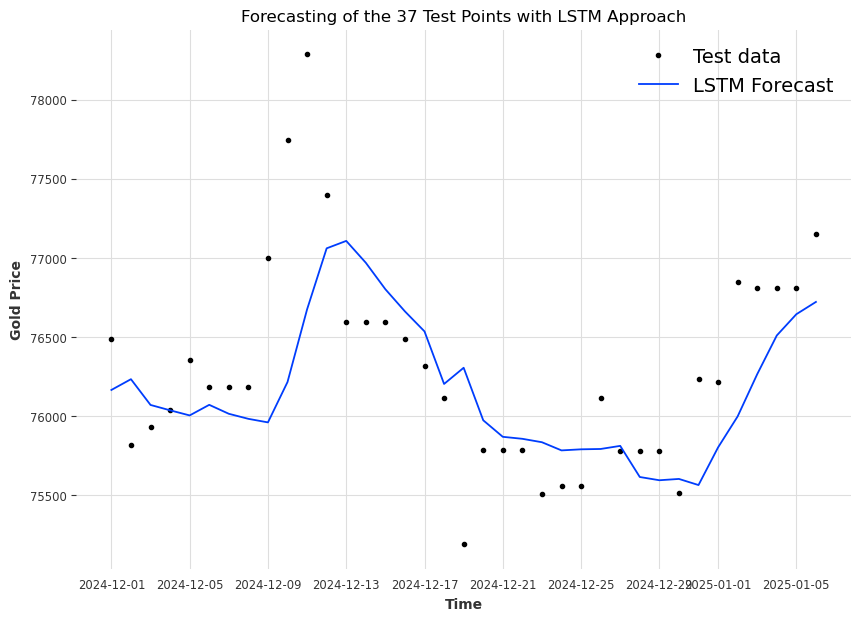

In [113]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with LSTM Approach')
plt.show()

In [114]:
lstm_metrics = evaluate_preds(y_true=y_test,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(384.39737),
 'mse': np.float32(291496.25),
 'rmse': np.float32(539.90393),
 'mape': np.float32(0.5012978)}

#### Evaluate Overfitting

In [115]:
holdout_exogenus_scaled_train = gold_price_exogenus_darts_scaled_train.slice(
    gold_price_exogenus_darts_scaled_train.time_index[2*split_size+1],
    gold_price_exogenus_darts_scaled_train.time_index[split_size]
)
not_holdout_exogenus_scaled_train = gold_price_exogenus_darts_scaled_train.slice(
    gold_price_darts_train.time_index[0],
    gold_price_darts_train.time_index[2*split_size]
)

In [116]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s]


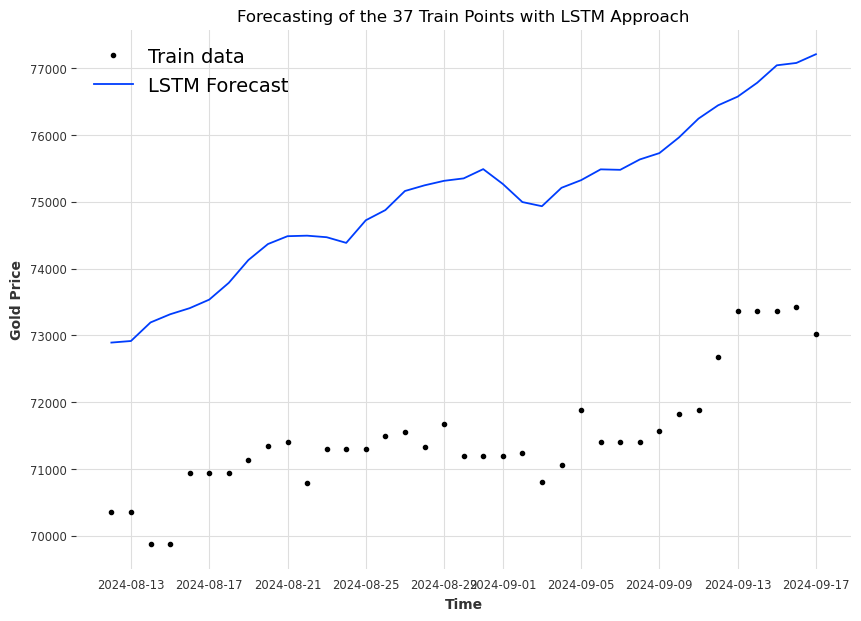

In [117]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with LSTM Approach')
plt.show()

In [118]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[2*split_size:split_size])
lstm_train_metrics

{'mae': np.float32(3560.1301),
 'mse': np.float32(12970617.0),
 'rmse': np.float32(3601.4744),
 'mape': np.float32(4.978133)}

### GRU - Gated Recurrent Unit Neural Network

#### Create Model

In [119]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=32,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=10
)

In [120]:
model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 9: 100%|██████████| 248/248 [00:05<00:00, 45.17it/s, train_loss=0.000249]


RNNModel(model=GRU, hidden_dim=32, n_rnn_layers=2, dropout=0.1, training_length=30, input_chunk_length=30, batch_size=16, n_epochs=10)

#### Make Predictions

In [121]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.47it/s] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.44it/s]


#### Evaluate Predictions

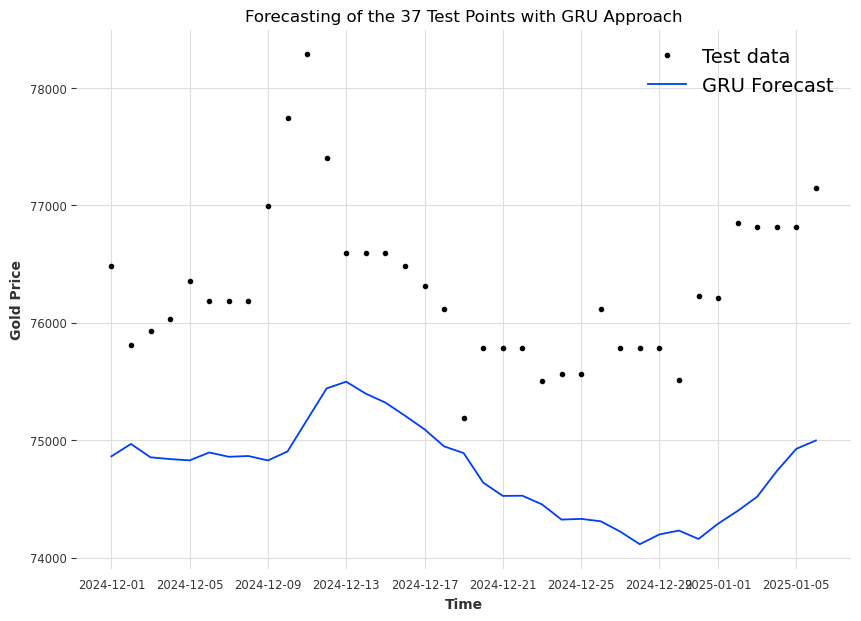

In [122]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title('Forecasting of the 37 Test Points with GRU Approach')
plt.show()

In [123]:
gru_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(1560.4905),
 'mse': np.float32(2744137.0),
 'rmse': np.float32(1656.5437),
 'mape': np.float32(2.040189)}

#### Evaluate Overfitting

In [124]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.70it/s]


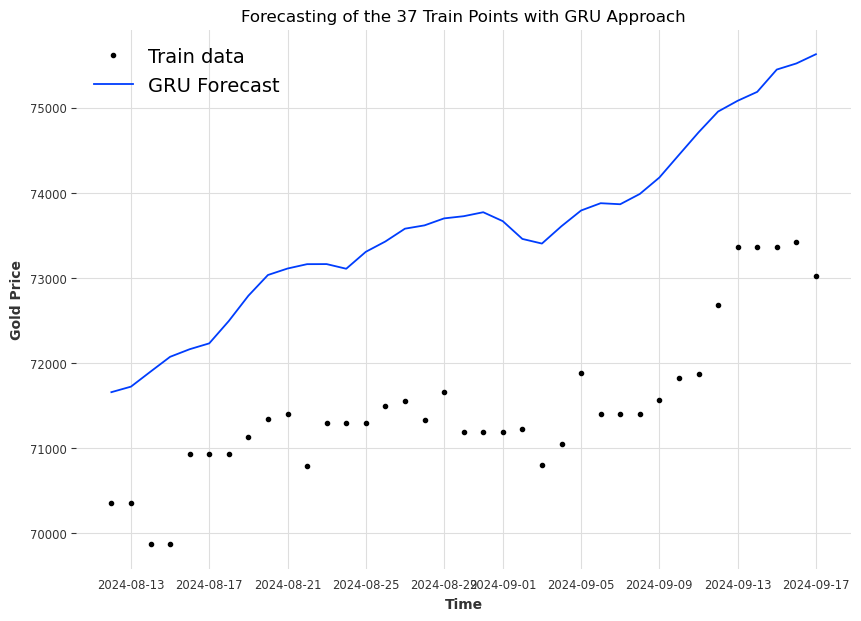

In [125]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with GRU Approach')
plt.show()

In [126]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[2*split_size:split_size])
gru_train_metrics

{'mae': np.float32(2092.6882),
 'mse': np.float32(4564118.0),
 'rmse': np.float32(2136.3796),
 'mape': np.float32(2.926499)}

### N-BEATSx

#### Create Model

In [127]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    n_epochs=10,
    random_state=42
)

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 9: 100%|██████████| 124/124 [00:22<00:00,  5.42it/s, train_loss=0.000326]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, random_state=42)

#### Make Predictions

In [128]:
from utils.preds import make_predictions_rolling_one_past_covariates_darts

In [129]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


#### Evaluate Predictions

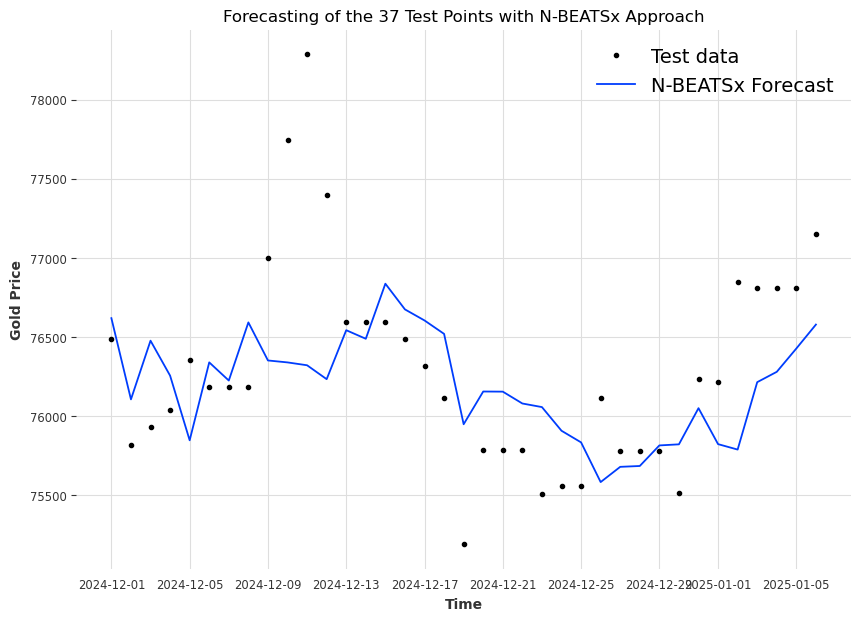

In [130]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title('Forecasting of the 37 Test Points with N-BEATSx Approach')
plt.show()

In [131]:
nbeatsx_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(446.20038),
 'mse': np.float32(354536.06),
 'rmse': np.float32(595.4293),
 'mape': np.float32(0.5819175)}

#### Evaluate Overfitting

In [132]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


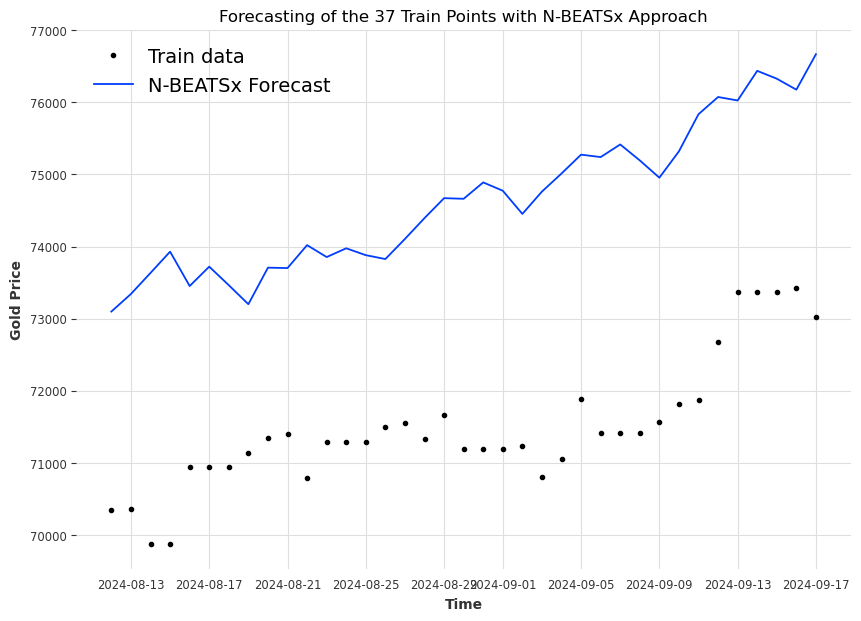

In [133]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with N-BEATSx Approach')
plt.show()

In [134]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[2*split_size:split_size])
nbeatsx_train_metrics

{'mae': np.float32(3143.32),
 'mse': np.float32(10202145.0),
 'rmse': np.float32(3194.0796),
 'mape': np.float32(4.39864)}